In [131]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np

In [132]:
class Product:
    INK = 'SQUID_INK'


In [133]:
prices = pd.concat([pd.read_csv(f'round4/prices_round_4_day_{i}.csv', sep=';') for i in range(1, 4)], ignore_index=True)
trades = pd.concat([pd.read_csv(f'round4/trades_round_4_day_{i}_nn.csv', sep=';') for i in range(1, 4)], ignore_index=True)
observations = []
for day in range(1, 4):
    odf = pd.read_csv(f'round4/observations_round_4_day_{day}.csv')
    odf['day'] = day
    observations.append(odf)
observations = pd.concat(observations, ignore_index=True)

In [134]:
ink = prices[prices['product'] == Product.INK].reset_index(drop=True).copy()
ink['time'] = ink['timestamp'] + (ink['day'] - 1) * 1_000_000

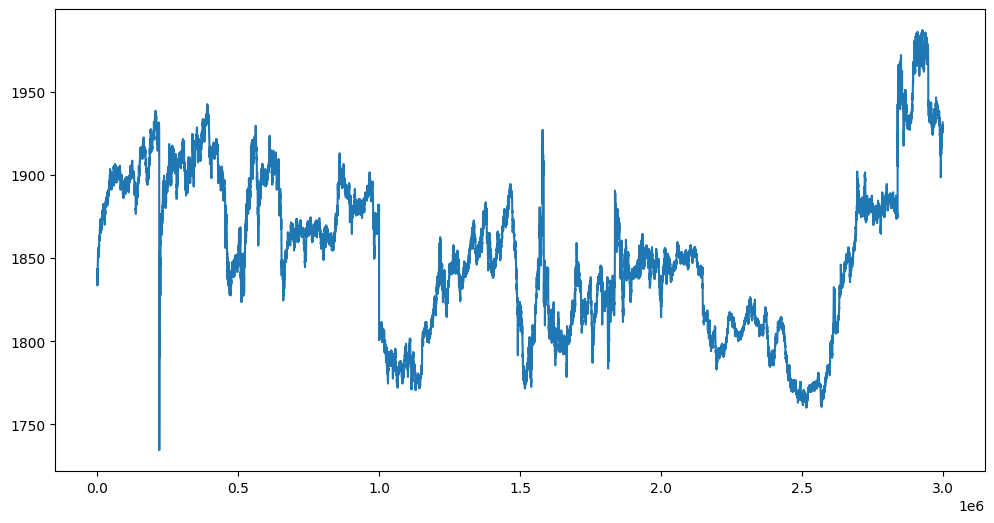

In [135]:
plt.figure(figsize=(12, 6))
plt.plot(ink['time'], ink['mid_price'])
plt.show()

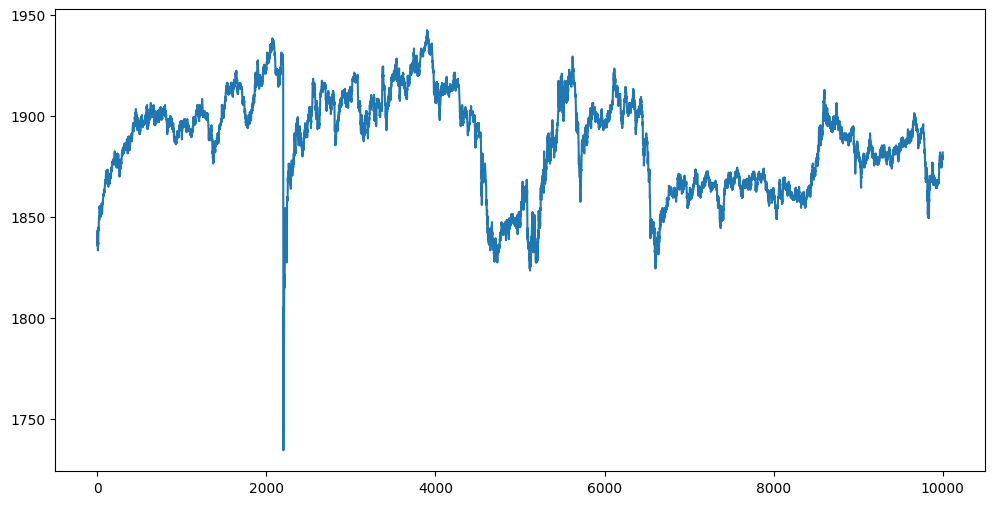

In [136]:
'''browse'''
# big spike window
data = ink[ink['day'] == 1].copy()
df = data.iloc[0:10000]

# browse = ink.iloc[3000:10000]
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['mid_price'])
plt.show()

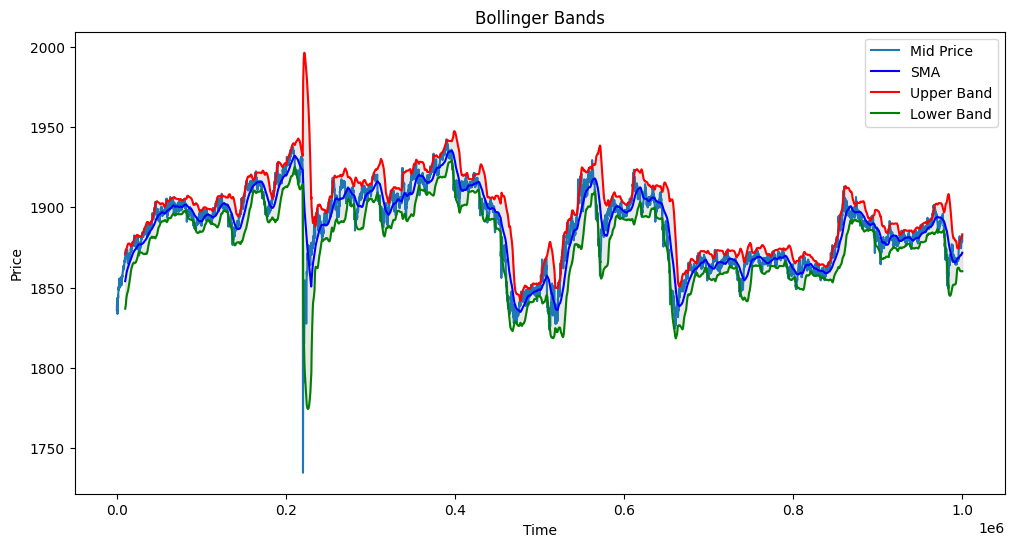

In [137]:
def bollinger_bands(data, column='mid_price', window=20, num_std=2):
    data['SMA'] = data[column].rolling(window=window).mean()
    data['STD'] = data[column].rolling(window=window).std()
    data['UPPER_BAND'] = data['SMA'] + (data['STD'] * num_std)
    data['LOWER_BAND'] = data['SMA'] - (data['STD'] * num_std)
    return data

# browse = bollinger_bands(browse, column='mid_price', window=20, num_std=2)
bollinger_bands(data, column='mid_price', window=100, num_std=2)

df = data.iloc[0:10000]

plt.figure(figsize=(12, 6))
plt.plot(df['time'], df['mid_price'], label='Mid Price')
plt.plot(df['time'], df['SMA'], label='SMA', color='blue')
plt.plot(df['time'], df['UPPER_BAND'], label='Upper Band', color='red')
plt.plot(df['time'], df['LOWER_BAND'], label='Lower Band', color='green')
plt.fill_between(df['time'], df['UPPER_BAND'], df['LOWER_BAND'], color='lightgray', alpha=0.5)
plt.title('Bollinger Bands')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()


In [ ]:
from tqdm import tqdm
def identify_regime(data, lookback=20):
    regimes = []
    
    for i in range(len(data)):
        if i < lookback:
            regimes.append('NEUTRAL')
        else:
            period = data.iloc[i-lookback+1:i+1]
            price = period['mid_price']
            upper = period['UPPER_BAND']
            lower = period['LOWER_BAND']
            
            # Count contiguous touches of upper and lower bands
            touched_upper = 0
            touched_lower = 0
            touching_upper = False
            touching_lower = False
            
            for j in range(len(period)):
                if price.iloc[j] >= upper.iloc[j]:
                    if not touching_upper:
                        touched_upper += 1
                        touching_upper = True
                    touching_lower = False
                elif price.iloc[j] <= lower.iloc[j]:
                    if not touching_lower:
                        touched_lower += 1
                        touching_lower = True
                    touching_upper = False
                else:
                    touching_upper = False
                    touching_lower = False
            
            if touched_upper > 1 and touched_lower > 1:
                regimes.append('OSCILLATING')
            elif touched_upper > 1:
                regimes.append('RIDING_UPPER')
            elif touched_lower > 1:
                regimes.append('RIDING_LOWER')
            else:
                regimes.append('NEUTRAL')
    
    return pd.Series(regimes, index=data.index)

regimes = identify_regime(data, lookback=300)

In [141]:
data['REGIME'] = regimes

In [124]:
from plotly import graph_objects as go

In [ ]:
fig = go.Figure()

fig.add_trace(go.Scatter(x=data['time'], y=data['mid_price'], mode='lines', name='Mid Price'))
fig.add_trace(go.Scatter(x=data['time'], y=data['SMA'], mode='lines', name='SMA', line=dict(color='blue')))
fig.add_trace(go.Scatter(x=data['time'], y=data['UPPER_BAND'], mode='lines', name='Upper Band', line=dict(color='red')))
fig.add_trace(go.Scatter(x=data['time'], y=data['LOWER_BAND'], mode='lines', name='Lower Band', line=dict(color='green')))
# Add regime switch points
regime_switch_points = regimes[regimes != regimes.shift(1)].dropna()
for idx, regime in regime_switch_points.items():
    fig.add_shape(type='line',
                  x0=data['time'].iloc[idx], y0=data['mid_price'].min(),
                  x1=data['time'].iloc[idx], y1=data['mid_price'].max(),
                  line=dict(color='black', width=1, dash='dash'))
    fig.add_trace(go.Scatter(x=[data['time'].iloc[idx]], y=[data['mid_price'].iloc[idx]],
                             mode='markers', marker=dict(size=0), hoverinfo='text',
                             text=f"Regime: {regime}"))
    
fig.update_layout(title='Bollinger Bands with Regime Switches',
                  xaxis_title='Time',
                  yaxis_title='Price',
                  legend=dict(x=0, y=1, traceorder='normal'))
fig.show()

In [ ]:
from collections import deque

lookback = 20
window = deque()

signal = []
means_without_outliers = []
std_without_outliers = []

cash = 0
position = 0
position_history = []

for idx, row in data.reset_index().iterrows():

    price = row['mid_price']

    if idx < lookback:
        signal.append('NEUTRAL')
        window.append(price)
        means_without_outliers.append(np.nan)
        std_without_outliers.append(np.nan)
        position_history.append(0)
        continue

    std = np.std(window)
    mean = np.mean(window)
    upper_band = mean + 3 * std
    lower_band = mean - 3 * std
    means_without_outliers.append(mean)
    std_without_outliers.append(std)

    # if price >= upper_band and window[-1] < upper_band:
    if price >= upper_band:
        signal.append('SHORT')
    # elif price <= lower_band and window[-1] > lower_band:
    elif price <= lower_band:
        signal.append('LONG')
    else:
        signal.append('NEUTRAL')

    window.append(price)
    
    if len(window) > lookback:
        window.popleft()

    if signal[-1] == 'LONG':
        position = 1
    elif signal[-1] == 'SHORT':
        position = -1
    else:
        position = 0

    position_history.append(position)


signal = pd.Series(signal, index=data.index)
mean_without_outliers = pd.Series(means_without_outliers, index=data.index)
std_without_outliers = pd.Series(std_without_outliers, index=data.index)
position_history = pd.Series(position_history, index=data.index)

In [189]:
position_history.value_counts()

 0    9642
 1     203
-1     155
Name: count, dtype: int64

In [190]:
position_history.diff().fillna(0).value_counts()

 0.0    9488
 1.0     256
-1.0     256
Name: count, dtype: int64

/var/folders/9p/y7yhf54d2yd5cdpt7hc80f2h0000gn/T/ipykernel_36262/1593708182.py:15: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[-1867.   1866.5 -1865.   1870.5  1882.5 -1882.   1880.5 -1880.   1886.5
 -1886.   1887.5 -1887.5  1893.  -1893.5  1898.5 -1898.5 -1895.5  1895.5
 -1894.5  1896.5  1898.5 -1897.5 -1893.5  1896.5 -1898.   1899.  -1899.5
  1900.  -1891.   1892.5 -1893.5  1895.5 -1888.5  1891.   1893.5 -1893.5
 -1888.5  1891.5 -1892.   1893.5  1899.5 -1896.5  1905.5 -1905.   1905.5
 -1904.5  1905.  -1905.   1907.5 -1908.5 -1888.5  1888.  -1881.5  1882.5
  1887.5 -1887.   1891.  -1889.5  1895.5 -1894.5  1898.5 -1897.5  1903.
 -1904.5  1916.  -1916.5 -1911.5  1911.   1921.5 -1921.5 -1912.5  1914.5
 -1913.5  1915.5 -1911.5  1912.  -1907.5  1907.  -1902.   1902.5  1913.5
 -1914.   1916.  -1912.5  1925.  -1926.5  1921.5 -1920.5  1926.  -1926.5
  1932.5 -1931.5 -1930.   1931.  -1925.5  1922.5 -1918.5  

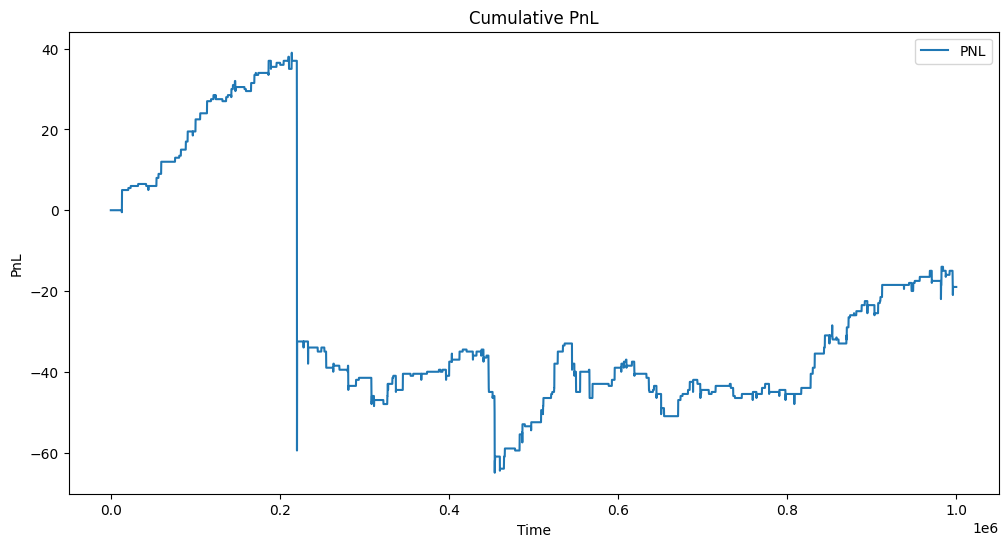

In [ ]:
# data['CASH'] = 0

# # Calculate the position differences
# data['POSITION_DIFF'] = data['POSITION'].diff().fillna(0)

# data.loc[data['POSITION_DIFF'] != 0, 'CASH'] = -data['POSITION_DIFF'] * data['mid_price']

# data['CUMULATIVE_CASH'] = data['CASH'].cumsum()

# data['PNL'] = data['CUMULATIVE_CASH'] + data['POSITION'] * data['mid_price']


df = data.copy()
df['CASH'] = 0
df['POSITION_DIFF'] = position_history.diff().fillna(0)
df.loc[df['POSITION_DIFF'] != 0, 'CASH'] = -df['POSITION_DIFF'] * df['mid_price']
df['CUMULATIVE_CASH'] = df['CASH'].cumsum()
df['PNL'] = df['CUMULATIVE_CASH'] + position_history * df['mid_price']
plt.figure(figsize=(12, 6))
plt.plot(df['time'], df['PNL'], label='PNL')
plt.title('Cumulative PnL')
plt.xlabel('Time')
plt.ylabel('PnL')
plt.legend()
plt.show()

In [200]:
data['mid_price'].iloc[2190:2210]

2190    1928.5
2191    1930.5
2192    1929.0
2193    1930.5
2194    1929.5
2195    1928.5
2196    1928.0
2197    1925.5
2198    1925.5
2199    1924.5
2200    1831.0
2201    1813.5
2202    1734.5
2203    1761.5
2204    1802.5
2205    1805.5
2206    1795.5
2207    1791.5
2208    1793.5
2209    1790.5
Name: mid_price, dtype: float64

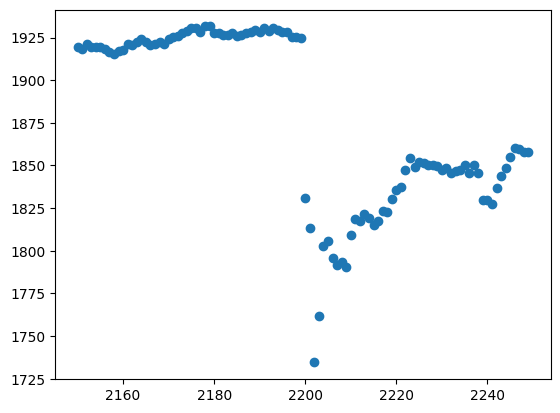

In [ ]:
plt.scatter(data['mid_price'].iloc[2150:2250].index, data['mid_price'].iloc[2150:2250])

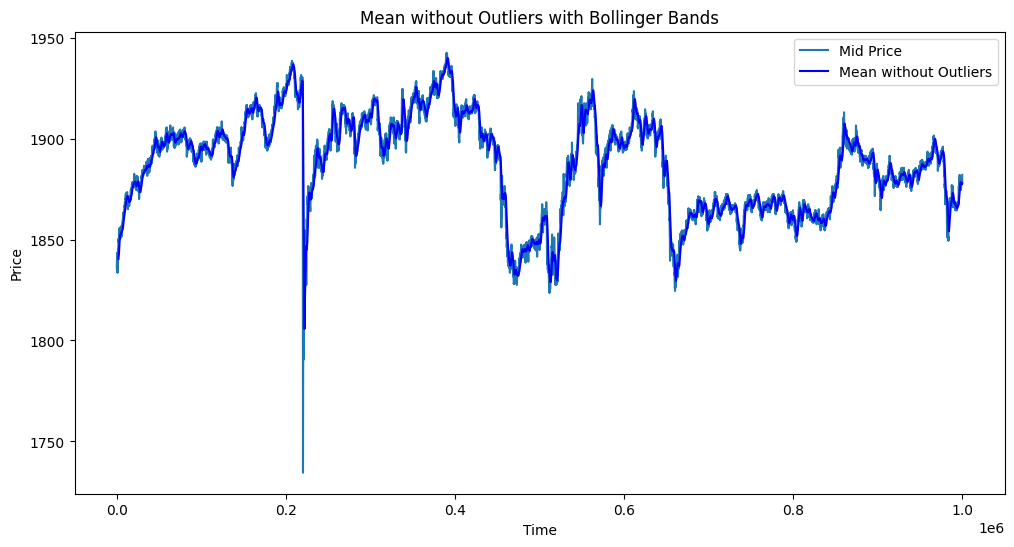

In [184]:
plt.figure(figsize=(12, 6))
plt.plot(data['time'], data['mid_price'], label='Mid Price')
plt.plot(data['time'], mean_without_outliers, label='Mean without Outliers', color='blue')
# plt.axhline(y=mean_without_outliers.mean() + 2 * mean_without_outliers.std(), color='red', linestyle='--', label='Upper Band')
# plt.axhline(y=mean_without_outliers.mean() - 2 * mean_without_outliers.std(), color='green', linestyle='--', label='Lower Band')
plt.title('Mean without Outliers with Bollinger Bands')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [144]:
def generate_signals(data):
    price = data['mid_price']
    upper = data['UPPER_BAND']
    lower = data['LOWER_BAND']
    regime = data['REGIME']
    sma = data['SMA']
    
    signals = pd.Series(index=data.index, dtype=object)
    
    for i in tqdm(range(1, len(data))):
        if regime[i] == 'OSCILLATING':
            if price[i] >= upper[i] and price[i-1] < upper[i-1]:
                signals[i] = 'SHORT'
            elif price[i] <= lower[i] and price[i-1] > lower[i-1]:
                signals[i] = 'LONG'
            
        elif regime[i] == 'NEUTRAL' and regime[i-1] != 'NEUTRAL':
            signals[i] = 'CLEAR'
        elif regime[i] == 'RIDING_UPPER' and regime[i-1] != 'RIDING_UPPER':
            if price[i] > sma[i]:
                signals[i] = 'CLEAR'
            else:
                signals[i] = 'LONG'
        elif regime[i] == 'RIDING_LOWER' and regime[i-1] != 'RIDING_LOWER':
            if price[i] < sma[i]:
                signals[i] = 'CLEAR'
            else:
                signals[i] = 'SHORT'
    
    return signals

data['SIGNAL'] = generate_signals(data)

100%|██████████| 9999/9999 [00:00<00:00, 149502.34it/s]


In [145]:
def update_position(signals):
    last_signal = None
    positions = []
    
    for signal in signals:
        if pd.notna(signal):
            last_signal = signal
        
        if last_signal == 'LONG':
            position = 60
        elif last_signal == 'SHORT':
            position = -60
        else:
            position = 0
        
        positions.append(position)
    
    return pd.Series(positions, index=signals.index)

data['POSITION'] = update_position(data['SIGNAL'])

In [149]:
data['SIGNAL'].value_counts()

SIGNAL
SHORT    142
LONG     103
CLEAR     19
Name: count, dtype: int64

In [147]:
# Initialize the "CASH" column with zeros
data['CASH'] = 0

# Calculate the position differences
data['POSITION_DIFF'] = data['POSITION'].diff().fillna(0)

data.loc[data['POSITION_DIFF'] != 0, 'CASH'] = -data['POSITION_DIFF'] * data['mid_price']

data['CUMULATIVE_CASH'] = data['CASH'].cumsum()

data['PNL'] = data['CUMULATIVE_CASH'] + data['POSITION'] * data['mid_price']

In [148]:
data['PNL']

0          0.0
1          0.0
2          0.0
3          0.0
4          0.0
         ...  
9995   -2520.0
9996   -2610.0
9997   -2520.0
9998   -2730.0
9999   -2730.0
Name: PNL, Length: 10000, dtype: float64

In [150]:
data['POSITION'].value_counts()

POSITION
 60    3878
-60    3616
 0     2506
Name: count, dtype: int64

In [151]:
import plotly.graph_objects as go

# Create the plot
fig = go.Figure()

# Add the CUMULATIVE_CASH line
fig.add_trace(go.Scatter(x=data['timestamp'], y=data['PNL'],
                         mode='lines', name='Cum'))

# Update the layout
fig.update_layout(title='Cumulative Cash Over Time',
                  xaxis_title='Timestamp',
                  yaxis_title='Cumulative Cash')

# Display the plot
fig.show()

<Axes: >

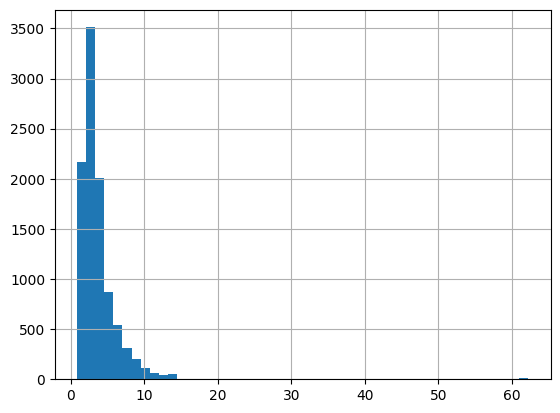

In [154]:
data['mid_price'].rolling(50).std().hist(bins=50)

In [ ]:
'''
bollinger band and hardcoding price shocks


try appending current price before calculating the rolling mean and std and after



if the price suddenly drops by a huge amount, we buy because ofc!? the drop and uptick spikes are very temporary
just have to find a good threshold to do this for

we can't do this with rolling window because ofc it doesn't make much sense to just use past prices, maybe rolling returns?

or maybe we can do this with rolling window of price and std like p2?

rolling window ignoring outliers? let's do histogram of standard deviation

what if return isn't 
'''

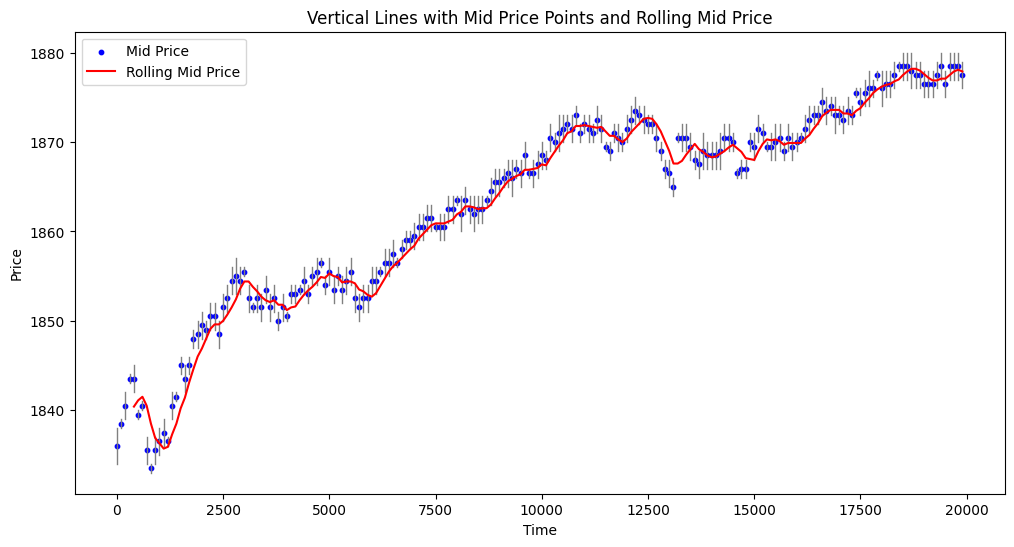

In [23]:
df = ink.iloc[:200]

plt.figure(figsize=(12, 6))
for _, row in df.iterrows():
    plt.plot([row['time'], row['time']], [row['bid_price_1'], row['ask_price_1']], color='gray', linestyle='-', linewidth=1)
    plt.scatter(row['time'], row['mid_price'], color='blue', label='Mid Price' if _ == 0 else "", s=10)
rolling_mid_price = df['mid_price'].rolling(window=5).mean()
plt.plot(df['time'], rolling_mid_price, color='red', label='Rolling Mid Price')
plt.xlabel('Time')
plt.ylabel('Price')
plt.title('Vertical Lines with Mid Price Points and Rolling Mid Price')
plt.legend()
plt.show()